# Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import gensim
from wordcloud import WordCloud, STOPWORDS
from gensim.models import KeyedVectors
import gensim.models.keyedvectors as word2vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape, Flatten, Concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from keras.models import model_from_json
import pickle
import json
import logging

logging.basicConfig(format='%(asctime)s : %(levelname) s : %(message)s', level=logging.INFO)

print('ALL LIBRARY IMPORTED.')

ALL LIBRARY IMPORTED.


# Load data

In [11]:
tweetData = pd.read_csv('data_simulasi/train.csv')
tweetData2 = pd.read_csv('data_simulasi/labeled_data.csv')

tweetData.drop('id', axis=1, inplace=True)
tweetData2['class'].replace({0: 1}, inplace=True)
tweetData2['class'].replace({2: 0}, inplace=True)
tweetData2 = tweetData2.rename(columns={'class':'label'})

tweetData = tweetData[['tweet','label']]
tweetData2 = tweetData2[['tweet','label']]

concat = [tweetData, tweetData2]
tweetData = pd.concat(concat)

print('Data loaded.')

Data loaded.


In [3]:
tweetData.head()

,tweet,label
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0


In [4]:
print(tweetData.shape)
print(tweetData.info())

(56745, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 56745 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   56745 non-null  object
 1   label   56745 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB
None


In [5]:
tweetData['label'].value_counts()

0    33883
1    22862
Name: label, dtype: int64

In [6]:
df = tweetData.copy()
print('Dataframe copied.')

Dataframe copied.


In [7]:
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
print('Done.')

Done.


# Data Cleaning & Preprocessing

## Casefolding

In [8]:
df['tweet_lower'] = df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df

,tweet,label,tweet_lower
0,@user when a father is dysfunctional and is s...,0,@user when a father is dysfunctional and is so...
1,@user @user thanks for #lyft credit i can't us...,0,@user @user thanks for #lyft credit i can't us...
2,bihday your majesty,0,bihday your majesty
3,#model i love u take with u all the time in ...,0,#model i love u take with u all the time in ur...
4,factsguide: society now #motivation,0,factsguide: society now #motivation
...,...,...,...
56740,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,1,you's a muthaf***in lie &#8220;@lifeasking: @2...
56741,"you've gone and broke the wrong heart baby, an...",0,"you've gone and broke the wrong heart baby, an..."
56742,young buck wanna eat!!.. dat nigguh like I ain...,1,young buck wanna eat!!.. dat nigguh like i ain...
56743,youu got wild bitches tellin you lies,1,youu got wild bitches tellin you lies


In [9]:
df.drop('tweet', axis=1, inplace=True)
print('Column `tweet` dropped.')

Column `tweet` dropped.


## Stopwords removal

In [10]:
stop = stopwords.words("english")
print('Stopwords defined.')

Stopwords defined.


In [11]:
df['tweet_stopwords'] = df['tweet_lower'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df

,label,tweet_lower,tweet_stopwords
0,0,@user when a father is dysfunctional and is so...,@user father dysfunctional selfish drags kids ...
1,0,@user @user thanks for #lyft credit i can't us...,@user @user thanks #lyft credit can't use caus...
2,0,bihday your majesty,bihday majesty
3,0,#model i love u take with u all the time in ur...,#model love u take u time urð±!!! ððð...
4,0,factsguide: society now #motivation,factsguide: society #motivation
...,...,...,...
56740,1,you's a muthaf***in lie &#8220;@lifeasking: @2...,you's muthaf***in lie &#8220;@lifeasking: @20_...
56741,0,"you've gone and broke the wrong heart baby, an...","gone broke wrong heart baby, drove redneck crazy"
56742,1,young buck wanna eat!!.. dat nigguh like i ain...,young buck wanna eat!!.. dat nigguh like aint ...
56743,1,youu got wild bitches tellin you lies,youu got wild bitches tellin lies


In [12]:
df.drop('tweet_lower', axis=1, inplace=True)
print('Column `tweet_lower` dropped.')

Column `tweet_lower` dropped.


## Punctuation words removal

In [13]:
df['tweet_punc'] = df['tweet_stopwords'].str.replace('(?:\@|http?\://|https?\://|www)\S+', '')
df['tweet_punc'] = df['tweet_punc'].str.replace('[^\w\s]', '')
df['tweet_punc'] = df['tweet_punc'].str.replace('[0-9]+', '')

df

<ipython-input-13-adcb5fd6fa0d>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tweet_punc'] = df['tweet_stopwords'].str.replace('(?:\@|http?\://|https?\://|www)\S+', '')
<ipython-input-13-adcb5fd6fa0d>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tweet_punc'] = df['tweet_punc'].str.replace('[^\w\s]', '')
<ipython-input-13-adcb5fd6fa0d>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tweet_punc'] = df['tweet_punc'].str.replace('[0-9]+', '')


,label,tweet_stopwords,tweet_punc
0,0,@user father dysfunctional selfish drags kids ...,father dysfunctional selfish drags kids dysfu...
1,0,@user @user thanks #lyft credit can't use caus...,thanks lyft credit cant use cause offer whee...
2,0,bihday majesty,bihday majesty
3,0,#model love u take u time urð±!!! ððð...,model love u take u time urð ðððð ððð
4,0,factsguide: society #motivation,factsguide society motivation
...,...,...,...
56740,1,you's muthaf***in lie &#8220;@lifeasking: @20_...,yous muthafin lie right tl trash now mine ...
56741,0,"gone broke wrong heart baby, drove redneck crazy",gone broke wrong heart baby drove redneck crazy
56742,1,young buck wanna eat!!.. dat nigguh like aint ...,young buck wanna eat dat nigguh like aint fuck...
56743,1,youu got wild bitches tellin lies,youu got wild bitches tellin lies


In [14]:
df.drop('tweet_stopwords', axis=1, inplace=True)
print('Column `tweet_stopwords` dropped.')

Column `tweet_stopwords` dropped.


## Frequent words removal

In [15]:
freq = pd.Series(' '.join(df['tweet_punc']).split()).value_counts()[:30]
freq

bitch      8278
rt         7635
like       3813
love       3349
im         3229
bitches    3110
day        2567
ð          2528
amp        2433
u          2423
hoes       2380
get        2347
pussy      2157
hoe        1917
â          1870
happy      1840
got        1819
ass        1638
time       1548
fuck       1526
one        1482
cant       1470
shit       1378
life       1378
good       1368
new        1278
go         1273
lol        1268
people     1266
know       1235
dtype: int64

In [16]:
freq = ['rt','im','ð','amp','u','â','retweet']
print('Most frequent words defined.')

Most frequent words defined.


In [17]:
df['tweet_comm_remv'] = df['tweet_punc'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df

,label,tweet_punc,tweet_comm_remv
0,0,father dysfunctional selfish drags kids dysfu...,father dysfunctional selfish drags kids dysfun...
1,0,thanks lyft credit cant use cause offer whee...,thanks lyft credit cant use cause offer wheelc...
2,0,bihday majesty,bihday majesty
3,0,model love u take u time urð ðððð ððð,model love take time urð ðððð ððð
4,0,factsguide society motivation,factsguide society motivation
...,...,...,...
56740,1,yous muthafin lie right tl trash now mine ...,yous muthafin lie right tl trash now mine bibl...
56741,0,gone broke wrong heart baby drove redneck crazy,gone broke wrong heart baby drove redneck crazy
56742,1,young buck wanna eat dat nigguh like aint fuck...,young buck wanna eat dat nigguh like aint fuck...
56743,1,youu got wild bitches tellin lies,youu got wild bitches tellin lies


In [18]:
df.drop('tweet_punc', axis=1, inplace=True)
print('Column `tweet_punc` dropped.')

Column `tweet_punc` dropped.


## Rare words removal

In [19]:
rare = pd.Series(' '.join(df['tweet_comm_remv']).split()).value_counts()[-100:]
rare = list(rare.index)
print('Rare words defined.')

Rare words defined.


In [20]:
df['tweet_rare_remv'] = df['tweet_comm_remv'].apply(lambda x: " ".join(x for x in x.split() if x not in rare))
df

,label,tweet_comm_remv,tweet_rare_remv
0,0,father dysfunctional selfish drags kids dysfun...,father dysfunctional selfish drags kids dysfun...
1,0,thanks lyft credit cant use cause offer wheelc...,thanks lyft credit cant use cause offer wheelc...
2,0,bihday majesty,bihday majesty
3,0,model love take time urð ðððð ððð,model love take time urð ðððð ððð
4,0,factsguide society motivation,factsguide society motivation
...,...,...,...
56740,1,yous muthafin lie right tl trash now mine bibl...,yous muthafin lie right tl trash now mine bibl...
56741,0,gone broke wrong heart baby drove redneck crazy,gone broke wrong heart baby drove redneck crazy
56742,1,young buck wanna eat dat nigguh like aint fuck...,young buck wanna eat dat nigguh like aint fuck...
56743,1,youu got wild bitches tellin lies,youu got wild bitches tellin lies


In [21]:
df.drop('tweet_comm_remv', axis=1, inplace=True)
print('Column `tweet_comm_remv` dropped.')

Column `tweet_comm_remv` dropped.


## Lemmatization

In [22]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Shavira
[nltk_data]     Zhalsabilla\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
lemmatizer = WordNetLemmatizer()

df['lemmatized'] = df['tweet_rare_remv'].apply(lambda x: " ".join(lemmatizer.lemmatize(x) for x in x.split()))

df

,label,tweet_rare_remv,lemmatized
0,0,father dysfunctional selfish drags kids dysfun...,father dysfunctional selfish drag kid dysfunct...
1,0,thanks lyft credit cant use cause offer wheelc...,thanks lyft credit cant use cause offer wheelc...
2,0,bihday majesty,bihday majesty
3,0,model love take time urð ðððð ððð,model love take time urð ðððð ððð
4,0,factsguide society motivation,factsguide society motivation
...,...,...,...
56740,1,yous muthafin lie right tl trash now mine bibl...,yous muthafin lie right tl trash now mine bibl...
56741,0,gone broke wrong heart baby drove redneck crazy,gone broke wrong heart baby drove redneck crazy
56742,1,young buck wanna eat dat nigguh like aint fuck...,young buck wanna eat dat nigguh like aint fuck...
56743,1,youu got wild bitches tellin lies,youu got wild bitch tellin lie


In [24]:
df.drop('tweet_rare_remv', axis=1, inplace=True)
print('Column `tweet_rare_remv` dropped.')

Column `tweet_rare_remv` dropped.


# Clean data

In [25]:
df = df.rename(columns={'lemmatized':'tweet'})
df.head()

,label,tweet
0,0,father dysfunctional selfish drag kid dysfunct...
1,0,thanks lyft credit cant use cause offer wheelc...
2,0,bihday majesty
3,0,model love take time urð ðððð ððð
4,0,factsguide society motivation


In [26]:
tweetData.reset_index(inplace=True)

df['unprepared_tweet'] = tweetData['tweet']
df.head(20)

,label,tweet,unprepared_tweet
0,0,father dysfunctional selfish drag kid dysfunct...,@user when a father is dysfunctional and is s...
1,0,thanks lyft credit cant use cause offer wheelc...,@user @user thanks for #lyft credit i can't us...
2,0,bihday majesty,bihday your majesty
3,0,model love take time urð ðððð ððð,#model i love u take with u all the time in ...
4,0,factsguide society motivation,factsguide: society now #motivation
5,0,huge fan fare big talking leave chaos pay disp...,[2/2] huge fan fare and big talking before the...
6,0,camping tomorrow dannyâ,@user camping tomorrow @user @user @user @use...
7,0,next school year year examsð cant think school...,the next school year is the year for exams.ð...
8,0,won love land allin cavs champion cleveland cl...,we won!!! love the land!!! #allin #cavs #champ...
9,0,welcome gr,@user @user welcome here ! i'm it's so #gr...


In [27]:
df.tail(20)

,label,tweet,unprepared_tweet
56725,1,gotta new breed retarded that,you gotta be a new breed of retarded if you do...
56726,1,gotta understand bitch childish,you gotta understand that these bitches are ch...
56727,1,hoe spice,you hoe spice
56728,1,want attention hoe,you just want some attention hoe
56729,0,know say early bird get worm put gummy worm mo...,"you know what they say, the early bird gets th..."
56730,1,know favorite tweet tryna cheat as bitch haha,you know what your doing when you favorite a t...
56731,1,lil dumb as bitch aint fuckin wit chu got mill...,"you lil dumb ass bitch, i ain't fuckin wit chu..."
56732,1,look like ac greenbitch call anymore,you look like AC Green...bitch don't call here...
56733,1,look like stop talking fucking bitch,you look like your 12 stop talking about fucki...
56734,1,might well gone pussy pop stage,you might as well gone pussy pop on a stage


In [28]:
df = df[['tweet','label']]
df

,tweet,label
0,father dysfunctional selfish drag kid dysfunct...,0
1,thanks lyft credit cant use cause offer wheelc...,0
2,bihday majesty,0
3,model love take time urð ðððð ððð,0
4,factsguide society motivation,0
...,...,...
56740,yous muthafin lie right tl trash now mine bibl...,1
56741,gone broke wrong heart baby drove redneck crazy,0
56742,young buck wanna eat dat nigguh like aint fuck...,1
56743,youu got wild bitch tellin lie,1


# Build corpus (tokenization)

In [29]:
corpus = df['tweet'].apply(gensim.utils.simple_preprocess)
corpus

0        [father, dysfunctional, selfish, drag, kid, dy...
1        [thanks, lyft, credit, cant, use, cause, offer...
2                                        [bihday, majesty]
3                [model, love, take, time, urð, ðððð, ððð]
4                        [factsguide, society, motivation]
                               ...                        
56740    [yous, muthafin, lie, right, tl, trash, now, m...
56741    [gone, broke, wrong, heart, baby, drove, redne...
56742    [young, buck, wanna, eat, dat, nigguh, like, a...
56743                [youu, got, wild, bitch, tellin, lie]
56744    [ruffled, ntac, eileen, dahlia, beautiful, col...
Name: tweet, Length: 56745, dtype: object

In [30]:
token = Tokenizer()
print('Done.')

Done.


In [31]:
token.fit_on_texts(corpus)
print('Done.')

Done.


In [32]:
token.index_word

{1: 'bitch',
 2: 'hoe',
 3: 'like',
 4: 'love',
 5: 'day',
 6: 'get',
 7: 'pussy',
 8: 'nigga',
 9: 'happy',
 10: 'got',
 11: 'time',
 12: 'as',
 13: 'one',
 14: 'fuck',
 15: 'life',
 16: 'cant',
 17: 'make',
 18: 'go',
 19: 'shit',
 20: 'good',
 21: 'want',
 22: 'know',
 23: 'people',
 24: 'today',
 25: 'girl',
 26: 'new',
 27: 'lol',
 28: 'see',
 29: 'aint',
 30: 'trash',
 31: 'need',
 32: 'me',
 33: 'look',
 34: 'take',
 35: 'positive',
 36: 'say',
 37: 'think',
 38: 'father',
 39: 'thankful',
 40: 'friend',
 41: 'back',
 42: 'you',
 43: 'really',
 44: 'never',
 45: 'thats',
 46: 'man',
 47: 'bihday',
 48: 'work',
 49: 'smile',
 50: 'still',
 51: 'come',
 52: 'ððð',
 53: 'way',
 54: 'right',
 55: 'ðð',
 56: 'it',
 57: 'going',
 58: 'year',
 59: 'let',
 60: 'bad',
 61: 'yall',
 62: 'thing',
 63: 'hate',
 64: 'even',
 65: 'fucking',
 66: 'best',
 67: 'bird',
 68: 'week',
 69: 'yo',
 70: 'feel',
 71: 'weekend',
 72: 'first',
 73: 'fun',
 74: 'family',
 75: 'would',
 76: 'always',
 77: 

In [100]:
token.texts_to_sequences(corpus)

[[38, 18543, 2516, 3662, 137, 9748, 334],
 [152, 7113, 1827, 16, 285, 160, 1429, 8192, 2348, 9749, 18544, 12308],
 [47, 4159],
 [142, 4, 34, 11, 198, 113, 52],
 [3883, 1666, 400],
 [935, 255, 6327, 125, 204, 302, 4801, 170, 12309, 6, 208, 18545],
 [2925, 108, 18546],
 [103, 143, 58, 58, 18547, 16, 37, 143, 1667, 63, 1577, 5212, 25],
 [3300, 4, 1350, 8193, 1430, 2265, 1612],
 [739, 3884],
 [1704, 3301, 1268, 2712, 243, 12310, 1453, 251, 153, 209, 185, 252],
 [2516, 140, 4160, 1124, 18548, 2516, 2040, 1431, 4],
 [6, 28, 525, 24, 5, 18549],
 [2041, 109, 4457, 1068, 143, 1866, 1351, 6328, 1037],
 [585, 1705, 12311, 2611, 12312],
 [18550, 18551, 3476, 18552, 359],
 [39, 2517, 39, 35],
 [960],
 [93, 49, 155, 173, 1108, 3663, 1613, 17, 23],
 [22, 2612, 994, 133, 8194],
 [354,
  23,
  4161,
  794,
  12313,
  634,
  271,
  7114,
  574,
  248,
  150,
  838,
  1215,
  12314,
  199,
  208],
 [116, 78, 314, 7115, 18553, 320, 1741, 193, 547],
 [1136, 5, 9, 46, 1069, 1432, 486, 71, 11, 403, 468, 111]

In [34]:
vocal = len(token.index_word)+1
print('There are {} words.'.format(vocal))

There are 49045 words.


# Exploratory Data Analysis

## Countplot label

C:\Users\Shavira Zhalsabilla\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


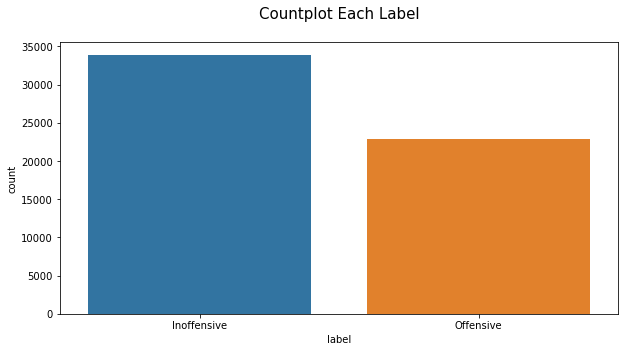

In [35]:
df_label = df['label'].replace({0: 'Inoffensive',
                               1: 'Offensive'})

plt.figure(figsize=(10,5))
sns.countplot(df_label)
plt.title('Countplot Each Label\n', fontsize=15)
plt.show()

## WordCloud for inoffensive & offensive tweets

In [36]:
inoffensive = df[df['label']==0]
offensive = df[df['label']==1]

print('Done.')

Done.


In [37]:
inoffensive_tweets = " ".join(tweet for tweet in inoffensive.tweet)
offensive_tweets = " ".join(tweet for tweet in offensive.tweet)

print("There are {} words in the combination of inoffensive tweets.".format(len(inoffensive_tweets)))
print('')
print ("There are {} words in the combination of offensive tweets.".format(len(offensive_tweets)))

There are 1843302 words in the combination of inoffensive tweets.

There are 1016324 words in the combination of offensive tweets.


In [38]:
stopwords = set(STOPWORDS)

print('Stopword set.')

Stopword set.


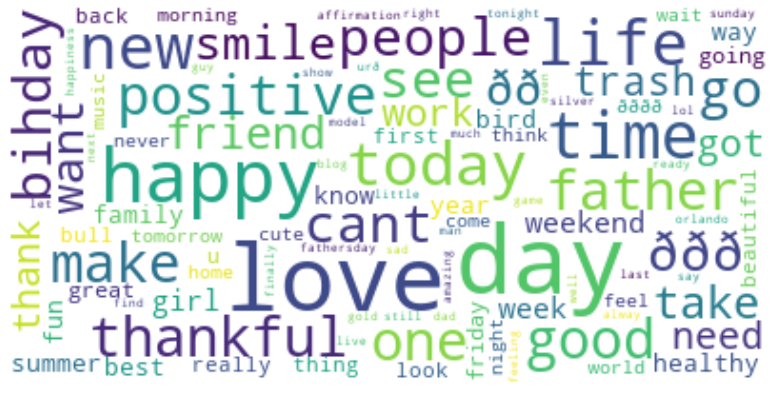

In [39]:
# Creating wordcloud for inoffensive tweets 

inoffensive_word_cloud = WordCloud(collocations = False, 
                                   background_color = 'white',
                                  max_words=100,
                                  max_font_size=50,
                                  stopwords=stopwords).generate(inoffensive_tweets)

# Display the generated Word Cloud
plt.figure(figsize=(15,7))
plt.imshow(inoffensive_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

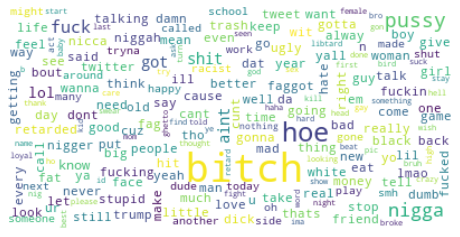

In [42]:
# Creating wordcloud for inoffensive tweets

offensive_word_cloud = WordCloud(collocations = False, 
                                   background_color = 'white',
                                  stopwords=stopwords,
                                max_font_size=35).generate(offensive_tweets)

# Display the generated Word Cloud
plt.figure(figsize=(8,7))
plt.imshow(offensive_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Build Google pre-trained Word2vec model

In [60]:
w2vModel = gensim.models.keyedvectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=150000)
print('Google pre-trained Word2vec model defined.')

2022-02-01 21:53:03,752 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin
2022-02-01 21:53:19,135 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (150000, 300) matrix of type float32 from GoogleNews-vectors-negative300.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2022-02-01T21:53:19.135979', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-8.1-6.3.9600-SP0', 'event': 'load_word2vec_format'}


Google pre-trained Word2vec model defined.


In [44]:
w2vModel.most_similar('apple')

[('apples', 0.720359742641449),
 ('pear', 0.6450697183609009),
 ('fruit', 0.6410146355628967),
 ('berry', 0.6302295327186584),
 ('pears', 0.613396167755127),
 ('strawberry', 0.6058260798454285),
 ('peach', 0.6025872826576233),
 ('potato', 0.5960935354232788),
 ('grape', 0.5935865044593811),
 ('blueberry', 0.5866668820381165)]

In [45]:
w2vModel.most_similar('hate')

[('despise', 0.6712517142295837),
 ('Hate', 0.6400399804115295),
 ('detest', 0.6179037094116211),
 ('hatred', 0.6156139969825745),
 ('hating', 0.6103580594062805),
 ('hates', 0.6091769933700562),
 ('HATE', 0.6020098328590393),
 ('dislike', 0.6013235449790955),
 ('love', 0.600395679473877),
 ('hated', 0.5922116637229919)]

In [46]:
result = w2vModel.most_similar(positive=['woman', 'king'], negative=['man'])
print("{}: {:.4f}".format(*result[0]))

queen: 0.7118


In [47]:
result = w2vModel.most_similar(positive=['orange', 'red'], negative=['orange'])
print("{}: {:.4f}".format(*result[0]))

yellow: 0.7519


# Pad sequences & defining x and y 

In [48]:
maxword = 30
print('Done.')

Done.


In [49]:
X = token.texts_to_sequences(corpus)
X = pad_sequences(X, maxlen = maxword, padding='post')
print('X defined.')

X defined.


In [50]:
X.shape

(56745, 30)

In [51]:
y = df['label'].values.tolist()
print('y defined.')

y defined.


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state = 42)
print('Training and testing data defined.')

Training and testing data defined.


# Word embedding 

In [61]:
embedding_layer = Embedding(input_dim=150000, output_dim=300, weights=[w2vModel.vectors], 
                            input_length=X.shape[1])
print('Embedding layer defined.')

Embedding layer defined.


# Build CNN model

In [62]:
print("training CNN ...")
model = Sequential()

'''EMBEDDING LAYER'''
model.add(embedding_layer)

'''CONVOLUTIONAL & POOLING LAYER'''
model.add(Conv1D(64, 7, activation='relu', padding='same'))
model.add(MaxPooling1D())
model.add(Conv1D(64, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))

'''DENSE LAYER/FULLY CONNECTED LAYER(?)'''
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dense(2, activation='softmax')) # output

'''OPTIMIZER FUNCTION (need to learn more)'''
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           45000000  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 64)            134464    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 15, 64)            28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3

C:\Users\Shavira Zhalsabilla\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


# Fitting CNN model

In [55]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print('Done.')

Done.


In [56]:
print('Jumlah training set:', len(X_train))
print('Jumlah testing set:', len(X_test))

Jumlah training set: 39721
Jumlah testing set: 17024


In [57]:
print("Training True: {0} ({1:2.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train)*100.0)))
print("Training False: {0} ({1:2.2f}%)\n".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train)*100.0)))

print("Testing True: {0} ({1:2.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test)*100.0)))
print("Testing False: {0} ({1:2.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test)*100.0)))

Training True: 15939 (40.13%)
Training False: 23782 (59.87%)

Testing True: 6923 (40.67%)
Testing False: 10101 (59.33%)


In [63]:
batch_size = 32
model.fit(X_train, y_train, epochs=3, verbose=1, batch_size=batch_size)

Epoch 1/3
1242/1242 [==============================] - 1028s 823ms/step - loss: 0.2153 - accuracy: 0.9181
Epoch 2/3
1242/1242 [==============================] - 1021s 822ms/step - loss: 0.0876 - accuracy: 0.9713
Epoch 3/3
1242/1242 [==============================] - 1022s 823ms/step - loss: 0.0387 - accuracy: 0.9887


# Model evaluation

In [64]:
loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=False)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

Model loss: 0.23323310911655426
Model acc: 0.9402020573616028


In [65]:
y_pred = model.predict(X_test)
print('Prediction done.')

Prediction done.


In [66]:
y_pred

array([[8.0628303e-04, 9.9919373e-01],
       [6.4177863e-02, 9.3582219e-01],
       [5.0789574e-03, 9.9492103e-01],
       ...,
       [9.9931669e-01, 6.8332069e-04],
       [2.1024082e-04, 9.9978977e-01],
       [9.9999952e-01, 5.1523000e-07]], dtype=float32)

In [67]:
labels = [0,1]

In [68]:
prediction_labels=[]
for p in y_pred:
    prediction_labels.append(labels[np.argmax(p)])

In [69]:
sum(y_test==prediction_labels)/len(prediction_labels)

0.9402020676691729

In [70]:
y_pred = prediction_labels

In [71]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[9585  516]
 [ 502 6421]]


In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10101
           1       0.93      0.93      0.93      6923

    accuracy                           0.94     17024
   macro avg       0.94      0.94      0.94     17024
weighted avg       0.94      0.94      0.94     17024



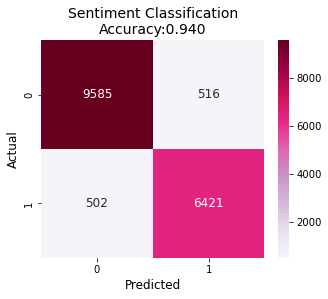

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     10101
           1       0.93      0.93      0.93      6923

    accuracy                           0.94     17024
   macro avg       0.94      0.94      0.94     17024
weighted avg       0.94      0.94      0.94     17024



In [73]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt=".0f", cmap="PuRd", annot_kws={"fontsize":12})
plt.title("Sentiment Classification\nAccuracy:{:.3f}".format(accuracy_score(y_test, y_pred)), fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred))

In [74]:
y_pred_train = model.predict(X_train)

In [75]:
labels_ = [0,1]

prediction_labels_=[]
for p in y_pred_train:
    prediction_labels_.append(labels[np.argmax(p)])
    
y_pred_train = prediction_labels_

In [76]:
cm_ = confusion_matrix(y_train, y_pred_train)

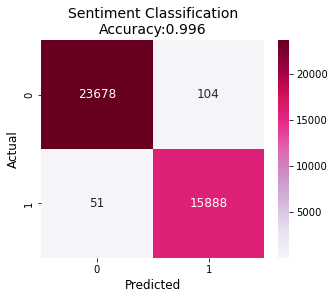

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23782
           1       0.99      1.00      1.00     15939

    accuracy                           1.00     39721
   macro avg       1.00      1.00      1.00     39721
weighted avg       1.00      1.00      1.00     39721



In [77]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_, annot=True,fmt=".0f", cmap="PuRd", annot_kws={"fontsize":12})
plt.title("Sentiment Classification\nAccuracy:{:.3f}".format(accuracy_score(y_train, y_pred_train)), fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()
print("Classification Report:\n", classification_report(y_train, y_pred_train))

# Model Inference

In [230]:
def predict_text(txt):
    
    txt = gensim.utils.simple_preprocess(txt)
    txt = token.texts_to_sequences(txt)
    txt = list(filter(None, txt))
    txt = np.reshape(txt, len(txt))
    txt = np.array([txt.tolist()])
    txt = pad_sequences(txt, maxlen = maxword, padding='post')
    
    predict = model.predict_classes(txt)
    
    if predict == 0:
        predict_text = ('Your text classification is {}, which means your text DOESN`T contains harmful word(s).'.format(predict))
    if predict == 1:
        predict_text = ('Your text classification is {}, which means your text contains harmful word(s).'.format(predict))
    
    return predict_text

In [237]:
txt = input('Input text')

predict_text(txt)

Input textBlack lives matter


C:\Users\Shavira Zhalsabilla\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'Your text classification is [1], which means your text contains harmful word(s).'

# Save model

## Tokenizer

In [241]:
token_file = open("token.pkl", "wb")
pickle.dump(token, token_file)
token_file.close()

## Word2vec

In [242]:
w2vModel.save_word2vec_format('w2vModel.bin', binary=True)

2022-02-02 00:38:35,444 : INFO : storing 150000x300 projection weights into w2vModel.bin


## Classification model

In [245]:
#Saving the model
model_json = model.to_json() # serialize model to JSON
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("classification_model.h5") # serialize weights to HDF5
print("Saved model to disk")

#Loading the model
# newmodel = model_from_json(open('model.json').read())
# newmodel.load_weights('smodel.h5')

Saved model to disk


# Load model

In [7]:
def predict_text(txt):
    
    txt = gensim.utils.simple_preprocess(txt)
    txt = token.texts_to_sequences(txt)
    txt = list(filter(None, txt))
    txt = np.reshape(txt, len(txt))
    txt = np.array([txt.tolist()])
    txt = pad_sequences(txt, maxlen = 30, padding='post')
    
    predict = model.predict_classes(txt)
    
    if predict == 0:
        predict_text = ('Your text classification is {}, which means your text DOESN`T contain harmful word(s).'.format(predict))
    if predict == 1:
        predict_text = ('Your text classification is {}, which means your text DOES contain harmful word(s).'.format(predict))
    
    return predict_text

In [3]:
pickle_file_read = open("token.pkl", "rb")
token = pickle.load(pickle_file_read)
print('File loaded.')

File loaded.


In [4]:
with open('model.json','r') as f:
    json = f.read()
model = model_from_json(json)

model.load_weights("classification_model.h5")

In [35]:
txt = input('')

predict_text(txt)

that chinese policewoman


C:\Users\Shavira Zhalsabilla\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'Your text classification is [1], which means your text DOES contain harmful word(s).'

In [16]:
df_test = pd.read_csv('data_simulasi/test.csv')
print('Data loaded.')

Data loaded.


In [22]:
df_test

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."
...,...,...
17192,49155,thought factory: left-right polarisation! #tru...
17193,49156,feeling like a mermaid ð #hairflip #neverre...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...
17195,49158,"happy, at work conference: right mindset leads..."


In [27]:
df_test['tweet'].loc[1564]

' â\x86\x9d #eur/usd neutral/bullish outlook â\x80\x93 scotiabank   #blog #silver #gold #forex'

In [28]:
predict_text(df_test['tweet'].loc[1564])

C:\Users\Shavira Zhalsabilla\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'Your text classification is [0], which means your text DOESN`T contain harmful word(s).'